Занятие 6. Линейная регрессия
===========

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

### Предсказание цены домов в Альбукерке

In [2]:
df = pd.read_csv('Albuquerque Home Prices.txt', sep='\t')
df = df.replace(-9999, np.nan)

In [3]:
df.head()

,PRICE,SQFT,AGE,FEATS,NE,CUST,COR,TAX
0,2050,2650,13.0,7,1,1,0,1639.0
1,2080,2600,NaN,4,1,1,0,1088.0
2,2150,2664,6.0,5,1,1,0,1193.0
3,2150,2921,3.0,6,1,1,0,1635.0
4,1999,2580,4.0,4,1,1,0,1732.0


Прежде, чем строить модель, нужно решить вопрос с пропущенными значениями. Сначала посчитаем, сколько строчек их содержат.

In [4]:
df[df.isnull().any(1)]

,PRICE,SQFT,AGE,FEATS,NE,CUST,COR,TAX
1,2080,2600,NaN,4,1,1,0,1088.0
8,1450,2150,NaN,4,1,0,0,NaN
15,1180,1830,NaN,3,1,0,0,733.0
19,995,1725,NaN,3,1,0,0,923.0
21,975,1430,NaN,3,1,0,0,752.0
22,975,1360,NaN,4,1,0,0,696.0
25,860,1385,NaN,2,1,0,0,653.0
28,1250,2277,NaN,4,1,1,0,NaN
29,1300,2000,NaN,3,1,1,0,1076.0
32,922,1326,NaN,4,1,0,0,668.0


In [5]:
print("Rows in the data frame: {}".format(df.shape[0]))
print("Rows without NAN: {}".format(df.dropna().shape[0]))

Rows in the data frame: 117
Rows without NAN: 66


Таким образом, около половины наших данных содержат хотя бы одно пропущенное значение. Учитывая то, что данных относительно мало, выбрасывать все такие строчки, было бы слишком расточительно.

Попробуем копнуть глубже и посмотреть на распределение пропущенных значений по колонкам.

Функция ```DataFrame.apply``` применяет указанную функцию ко всей таблице. Первый аргумент -- применяемая функция, второй аргумент -- направление её применения (0 -- применить к колонкам, 1 -- ко строчкам).

In [6]:
df.apply(lambda x: sum(x.isnull()), axis=0)

PRICE     0
SQFT      0
AGE      49
FEATS     0
NE        0
CUST      0
COR       0
TAX      10
dtype: int64

Для определения функции здесь использовано так называемое лямбда-выражение (лямбда-функция). Это способ записать короткую функцию в одну строчку, не задавая её имени. В данном случае такое лямбда-выражение эквивалентно следующему определению функции:

`
def f(x):
    return sum(x.isnull())
`

Таким образом, видим, что источниками пропущенных значений являются колонки ```AGE``` и ```TAX```. Раз в колонке ```AGE``` так много пропусков, то проще её будет убрать из анализа, чем пытаться заделать эти дырки.

In [7]:
df.drop(columns='AGE', axis=1, inplace=True)

А колонку ```TAX``` можно попробовать починить. Чтобы это сделать, сначала посмотрим, как выглядит распределение этой колонки.

<AxesSubplot:>

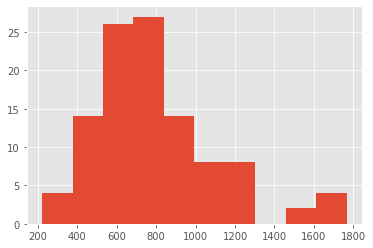

In [8]:
df['TAX'].hist()

Раз распределение похоже на нормальное, то можно заменить пропуски на среднее значение этой колонки. Для этого в pandas есть функция ```Series.fillna```, которая заменяет все пропущенные в колонке значения на заданное.

In [9]:
df['TAX'] = df['TAX'].fillna(float(int(df['TAX'].mean())))

<AxesSubplot:>

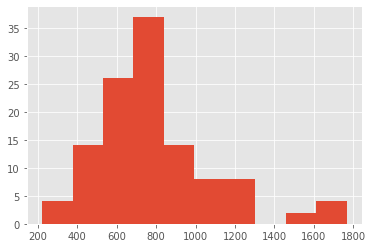

In [10]:
df['TAX'].hist()

Убедимся, что все проблемы с пропусками устранены. Длина таблицы с пропусками равна длине исходного датасета.

In [11]:
len(df.dropna())

117

#### Построение модели

Теперь можно переходить непосредственно к построению модели.

In [12]:
from sklearn.linear_model import LinearRegression

In [13]:
X = df.drop('PRICE', axis=1) # Матрица параметров
y = df['PRICE'] # Целевая функция/параметр PRICE

In [14]:
lr = LinearRegression()
lr.fit(X, y)

LinearRegression()

Считаем качество модели (коэффициент $R^2$).

In [15]:
print("R^2: {}".format(lr.score(X, y)))

R^2: 0.8022841702703369


Выведем регрессионные коэффициенты от метода ```model.coef_``` и свободный член от метода ```model.intercept_```.

In [16]:
lr.coef_

array([  0.29183622,  12.17237975,   8.00803332, 133.03455297,
       -65.79528124,   0.54221148])

In [17]:
lr.intercept_

83.23099173731396

In [18]:
coef = pd.DataFrame(zip(['intercept'] + X.columns.tolist(), [lr.intercept_] + lr.coef_.tolist()), 
                   columns=['predictor', 'coef'])
coef

,predictor,coef
0,intercept,83.230992
1,SQFT,0.291836
2,FEATS,12.172380
3,NE,8.008033
4,CUST,133.034553
5,COR,-65.795281
6,TAX,0.542211


К сожалению, в ```sklearn``` не предусмотрена процедура определения статистической значимости регрессионных коэффициентов. Поэтому нужно это делать либо руками, вооружившись знанием о распределении коэффициентов, либо воспользовавшись моделью из пакета ```statsmodels```.

In [19]:
from scipy import stats

def regression_coef(model, X, y):
    coef = pd.DataFrame(zip(['intercept'] + X.columns.tolist(), [model.intercept_] + model.coef_.tolist()),
                    columns=['predictor', 'coef'])
    X1 = np.append(np.ones((len(X),1)), X, axis=1)
    b = np.append(model.intercept_, model.coef_)
    MSE = np.sum((model.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])
    var_b = MSE * (np.linalg.inv(np.dot(X1.T, X1)).diagonal())
    sd_b = np.sqrt(var_b)
    t = b / sd_b
    coef['pvalue'] = [2 * (1 - stats.t.cdf(np.abs(i), (len(X1) - 1))) for i in t]
    return coef
regression_coef(lr, X, y)

,predictor,coef,pvalue
0,intercept,83.230992,1.891720e-01
1,SQFT,0.291836,2.606827e-06
2,FEATS,12.172380,3.420404e-01
3,NE,8.008033,8.191010e-01
4,CUST,133.034553,3.446092e-03
5,COR,-65.795281,1.168526e-01
6,TAX,0.542211,4.914143e-07


#### TAX наименее значимый так как меньше всего значение P-Value

Как интерпретировать модель? У нас есть 3 значимых предиктора: ```SQFT```, ```CUST``` и ```TAX```.  


In [20]:
df.corr()

,PRICE,SQFT,FEATS,NE,CUST,COR,TAX
PRICE,1.000000,0.844795,0.420272,0.167840,0.555292,-0.079293,0.844948
SQFT,0.844795,1.000000,0.394925,0.145030,0.520102,0.040528,0.832713
FEATS,0.420272,0.394925,1.000000,0.190016,0.241964,-0.041547,0.419476
NE,0.167840,0.145030,0.190016,1.000000,0.043033,-0.077336,0.189220
CUST,0.555292,0.520102,0.241964,0.043033,1.000000,-0.003994,0.444883
COR,-0.079293,0.040528,-0.041547,-0.077336,-0.003994,1.000000,-0.058297
TAX,0.844948,0.832713,0.419476,0.189220,0.444883,-0.058297,1.000000


Налоги сильно коррелируют с площадью. Предлагается откинуть налоги.

In [21]:
X_new = df[['SQFT', 'CUST']]
lr.fit(X_new, y)
print (lr.score(X_new, y))
regression_coef(lr, X_new, y)

0.7320966420178658


,predictor,coef,pvalue
0,intercept,114.134824,0.082734
1,SQFT,0.553635,0.000000
2,CUST,142.859931,0.005787


### Полиномиальная регрессия

In [22]:
df = pd.read_csv('diamond.dat', header=None, sep='\s+', names=['weight', 'price'])

In [23]:
df.head()

,weight,price
0,0.17,355
1,0.16,328
2,0.17,350
3,0.18,325
4,0.25,642


Будем предсказывать цену кольца с бриллиантом от веса бриллианта. Попробуем предсказать результат не только с помощью самой переменной, но и с помощью её степеней. Первая модель будет зависеть только от самой переменной ```weight```, вторая -- от переменной ```weight^2```, а третья -- от двух этих переменных сразу.

В этих случаях, когда мы хотим попробовать в качестве фичей их степени и произведения фич, в ```sklearn.preprocessing``` есть класс ```PolynomialFeatures```. Метод ```fit_transform``` этого класса сгенерирует из данного множества фич множество одночленов заданной степени. Например, для степени 2 и фич ```a```, ```b``` будут сгенерированы фичи ```[a, b, a^2, b^2, ab]```, а при указанном параметре ```include_bias=True``` ещё и вектор-свободный член из единиц. Для данной задачи, конечно, проще было сгенерить один столбец из квадратов значений колонки ```weight```. Но нам важно ознакомиться с классом ```PolynomialFeatures``` для дальнейшего применения.

In [24]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(
                          # Максимальная степень
                          degree=2,
                          # Не генерировать свободный член
                          include_bias=False)
y = df['price']
X0 = poly.fit_transform(df[['weight']])
X0 = pd.DataFrame(X0, columns=['weight', 'weight^2'])
X0.head()

,weight,weight^2
0,0.17,0.0289
1,0.16,0.0256
2,0.17,0.0289
3,0.18,0.0324
4,0.25,0.0625


In [25]:
X0 = [
    # Одна оригинальная переменная weight
    X0[['weight']],
    # Одна переменная weight^2
    X0[['weight^2']],
    # Две переменных weight и weight^2
    X0.copy()]
models = [LinearRegression() for _ in X0]

In [26]:
X0

[    weight
 0     0.17
 1     0.16
 2     0.17
 3     0.18
 4     0.25
 5     0.16
 6     0.15
 7     0.19
 8     0.21
 9     0.15
 10    0.18
 11    0.28
 12    0.16
 13    0.20
 14    0.23
 15    0.29
 16    0.12
 17    0.26
 18    0.25
 19    0.27
 20    0.18
 21    0.16
 22    0.17
 23    0.16
 24    0.17
 25    0.18
 26    0.17
 27    0.18
 28    0.17
 29    0.15
 30    0.17
 31    0.32
 32    0.32
 33    0.15
 34    0.16
 35    0.16
 36    0.23
 37    0.23
 38    0.17
 39    0.33
 40    0.25
 41    0.35
 42    0.18
 43    0.25
 44    0.25
 45    0.15
 46    0.26
 47    0.15,
     weight^2
 0     0.0289
 1     0.0256
 2     0.0289
 3     0.0324
 4     0.0625
 5     0.0256
 6     0.0225
 7     0.0361
 8     0.0441
 9     0.0225
 10    0.0324
 11    0.0784
 12    0.0256
 13    0.0400
 14    0.0529
 15    0.0841
 16    0.0144
 17    0.0676
 18    0.0625
 19    0.0729
 20    0.0324
 21    0.0256
 22    0.0289
 23    0.0256
 24    0.0289
 25    0.0324
 26    0.0289
 27    0.0324
 28  

In [27]:
for X, model in zip(X0, models):
    model.fit(X, y)
    print (model.score(X, y))

0.978260777986033
0.970310818417109
0.9789175801893899


Получилось, что $R^2$ во всех моделях примерно одинаков. Однако не все они одинаково полезны. 

# Одна оригинальная переменная weight

In [36]:
regression_coef(models[0], X0[0], y)

,predictor,coef,pvalue
0,intercept,-259.625907,0.0
1,weight,3721.024852,0.0


In [41]:
real_b, real_a = regression_coef(models[0], X0[0], y)['coef']
print("A = {} | B = {}".format(real_a, real_b))

A = 3721.024851550474 | B = -259.6259071915552


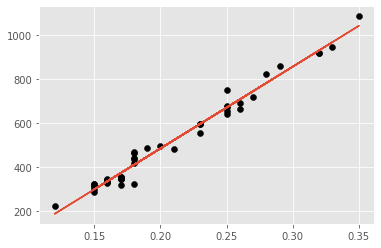

In [40]:
plt.scatter(x=X0[0], y=y, c='black')
plt.plot(X0[0], real_a*X0[0] + real_b)
plt.show()

# Одна переменная weight^2

In [29]:
regression_coef(models[1], X0[1], y)

,predictor,coef,pvalue
0,intercept,141.659045,0.0
1,weight^2,7993.108083,0.0


In [42]:
real_b, real_a = regression_coef(models[1], X0[1], y)['coef']
print("A = {} | B = {}".format(real_a, real_b))

A = 7993.108083345929 | B = 141.65904502929624


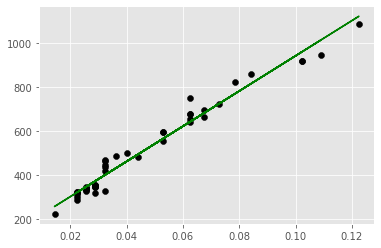

In [43]:
plt.scatter(x=X0[1], y=y, c='black')
plt.plot(X0[1], real_a*X0[1] + real_b, c='green')
plt.show()

# Две переменных weight и weight^2

In [45]:
regression_coef(models[2], X0[2], y)

,predictor,coef,pvalue
0,intercept,-174.130082,0.021866
1,weight,2920.130591,0.000077
2,weight^2,1739.901579,0.237265


In [47]:
real_b, real_a_1, real_a_2 = regression_coef(models[2], X0[2], y)['coef']
print("A1 = {} | A2 = {} | B = {}".format(real_a_1, real_a_2, real_b))

A1 = 2920.130591052773 | A2 = 1739.9015792812581 | B = -174.13008232421163


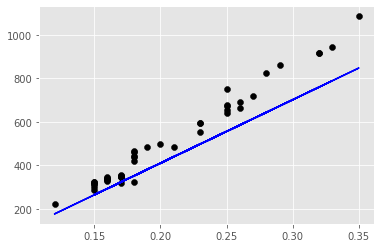

In [56]:
plt.scatter(x=X0[2]['weight'], y=y, c='black')
plt.plot(X0[2]['weight'], real_a_1*X0[2]['weight'] + real_b, c='blue')
plt.show()

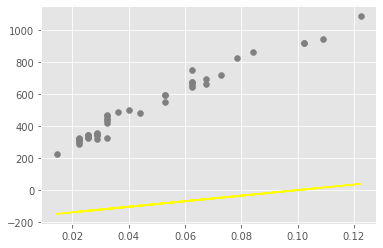

In [55]:
plt.scatter(x=X0[2]['weight^2'], y=y, c='grey')
plt.plot(X0[2]['weight^2'], real_a_2*X0[2]['weight^2'] + real_b, c='yellow')
plt.show()

In [33]:
import statsmodels.api as sm
X2 = sm.add_constant(X0[2])
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     1045.
Date:                Tue, 22 Mar 2022   Prob (F-statistic):           1.94e-38
Time:                        10:26:27   Log-Likelihood:                -232.47
No. Observations:                  48   AIC:                             470.9
Df Residuals:                      45   BIC:                             476.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -174.1301     74.238     -2.346      0.0

### Прогнозирование временных рядов.

In [57]:
df = pd.read_csv('series_g.csv', sep=';')
df.head()

,date,series_g
0,JAN 1949,112
1,FEB 1949,118
2,MAR 1949,132
3,APR 1949,129
4,MAY 1949,121


In [58]:
# Преобразуем строчки с датами в объект datetime
# format='%b %Y' означает, что в нашей строчке сначала идёт трёхбуквенное название месяца (%b), а затем год (%Y)
df['date'] = pd.to_datetime(df['date'], format='%b %Y')

In [62]:
df.dtypes

date        datetime64[ns]
series_g             int64
dtype: object

Построим графики объёма пассажироперевозок и проверим, какой тип тренда (линейный или нет) и какой тип сезонности ( аддитивный или мультипликативный), наблюдается. По первому графику уже прослеживается линейный тренд и мультипликативная сезонность. Но чтобы окончательно убедиться в последнем, добавим график логарифма от этой же величины. После логирафмирования циклы стали одинаковой высоты, а это и говорит о мультипликативном харакрете сезонности.

Text(0, 0.5, 'log10 от тысяч человек')

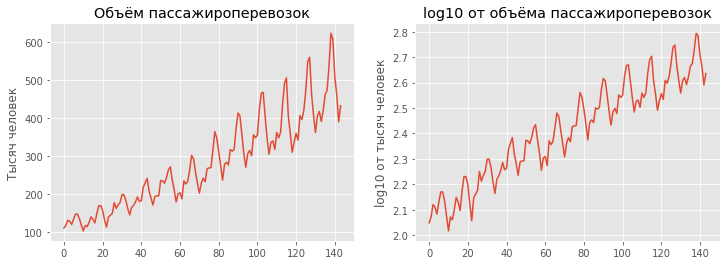

In [63]:
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(121)
df['series_g'].plot(ax=ax1)
ax1.set_title(u'Объём пассажироперевозок')
ax1.set_ylabel(u'Тысяч человек')

ax2 = fig.add_subplot(122)
pd.Series(np.log10(df['series_g'])).plot(ax=ax2)
ax2.set_title(u'log10 от объёма пассажироперевозок')
ax2.set_ylabel(u'log10 от тысяч человек')


Вывод: будем строить модель линейной регрессии для приближения логарифма от объёма перевозок. То есть
$$\log y_i = \beta x_i + c(x_i) + \varepsilon_i,$$
где $y_i$ -- объём перевозок, $x_i$ -- порядковый номер месяца, $c(x_i)$ -- сезонная составляющая, $\varepsilon_i$ -- случайный шум.

Для удобства дальнейшего использования создадим дополнительно 12 новых месяцев для построения прогноза на них. Для этого создадим эти 12 новых дат с помощью функции ```pd.date_range```. Данный объект будет объектом класса ```DateTimeIndex``` (наследованный от класса ```Index```), и чтобы объединить их с колонкой ```df['date']```, принадлежащей классу ```datetime64```, придётся привести последнюю к классу ```Index```. Объединим два набора дат и сохраним их в объекте ```new_dates```.

Далее создадим фиктивный датафрейм ```df2```, состоящий из одной колонки с этими новыми датами, и приклеим его к исходному датафрейму ```df``` с помозью функции ```pd.merge```. Эта функция склеивает два датасета по указанному набору колонок (параметр ```on```) и по указанному правилу склейки (параметр ```how```). В ```on``` указываем одну общую колонку ```date```, по которой нужно произвести склейку. В ```how``` указываем ```right```, что означает следующее: 
возьми весь правый датасет и приклей к нему левый датасет по условию совпадения значений колонки ```on```, а в случае если для значений из правой колонки ```on``` не найдётся соотвествующих значений в левой колонке ```on```, то тогда приклей ```NaN``` значения. Вообще говоря, опция ```how``` соответствует опциям ```JOIN``` в языке SQL (```LEFT JOIN```, ```RIGHT_JOIN```, ```INNER JOIN```, ```OUTER_JOIN```).

In [64]:
# Создаём последовательность месяцев. freq='MS' означает первое число каждого месяца из указанного диапазона дат
new_dates = pd.date_range('1961-01-01', '1961-12-01', freq='MS')
# Приводим df['date'] к типу Index, объединяем с 12 месяцами, полученными на предыдущем шаге
new_dates = pd.Index(df['date']) | new_dates
# Создаём датафрейм из одной колонки с расширенным набором дат
df2 = pd.DataFrame({'date': new_dates})
# Объединяем два датафрейма по колонке 'date'.
df = pd.merge(df, df2, on='date', how='right')

C:\Users\vsevo\AppData\Local\Temp/ipykernel_14136/3281240587.py:4: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  new_dates = pd.Index(df['date']) | new_dates


Создадим регрессионную переменную ```month_num``` -- порядковый номер пары (месяц, год). И прологарифмируем таргет.

In [65]:
df['month_num'] = range(1, len(df) + 1)
df['log_y'] = np.log10(df['series_g'])

Создадим 12 колонок ```season_1```, ```season_2```, ..., ```season_12```, в которые поместим индикаторы соответствующего месяца. Чтобы достать порядковый номер месяца в каждой строчке, применим последовательно пару методов ```dt``` и ```month``` к колонке ```df['date']```. Внутри цикла будем проверять, равен ли очередной месяц текущему значению из цикла.

In [66]:
for x in range(1, 13):
    df['season_' + str(x)] = df['date'].dt.month == x

Правда, для устранения линейной зависимости между колонками, один из сезонных индикаторов придётся исключить. Пусть базовым месяцем будет январь.

In [67]:
# xrange(2, 13) соответствует всем месяцам с февраля по декабрь
season_columns = ['season_' + str(x) for x in range(2, 13)]

# Создадим объекты матрицу X и вектор y для обучения модели
X = df[['month_num'] + season_columns]
y = df['log_y']

# Оставим только те строчки, у которых известны значения y (с номером < 144)
X1 = X[X.index < 144]
y1 = y[y.index < 144]

Настраиваем линейную регрессионную модель.

In [68]:
model = LinearRegression()
model.fit(X1, y1)

LinearRegression()

<AxesSubplot:>

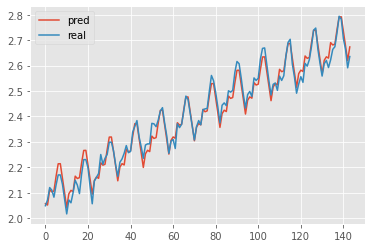

In [69]:
pred = pd.DataFrame({
    'pred': model.predict(X1),
    'real': y1})
pred.plot()

Теперь построим предсказание для всей матрицы ```X```, включая неизвестные 12 месяцев.

<AxesSubplot:>

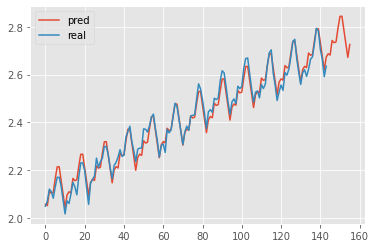

In [70]:
pred = pd.DataFrame({
    'pred': model.predict(X),
    'real': y})
pred.plot()